
<img src="https://i.imgur.com/gb6B4ig.png" width="400" alt="Weights & Biases" />

<!--- @wandbcode{electricity_prices_timeseries, version=webinar} -->




# Time Series Forecasting with GreyKite and W&B

In this notebook we'll examine how to forecast hourly electricty prices for the following 24hours and how to plot and log all of our forecasting experiments using Weights & Biases.

### GreyKite

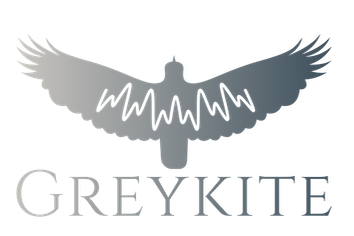

[GreyKite](https://github.com/linkedin/greykite) is a Time Series forecasting library built by [LinkedIn Engineering](https://engineering.linkedin.com/blog/2021/greykite--a-flexible--intuitive--and-fast-forecasting-library) for their forecasting needs. Alongside its feature-rich tool set comes the `Silverkite` algorithm which decomposes time series into various components, creates time-based features and autoregressive features. Together with user-provided features such as macro-economic features and their interactions, it then runs a regression model to learn the relationship between the time series and these features. The forecast is based on the learned relationship and the future values of these features. 

### Credit
Much of the code here is based off the guides in the [GreyKite docs](https://linkedin.github.io/greykite/docs/0.1.0/html/gallery/quickstart/index.html) which are really excellent. Highly recommend going through those guides for a more indepth exploration of all of the GreyKite functionality.

## Setup

If you have any issues installing greykite, have a look at their [installation docs](https://linkedin.github.io/greykite/installation.html) which are quite thorough and address a wide range of platforms and potential error messages

In [ ]:
!pip install -qq wandb --upgrade

In [ ]:
!python -m pip -q install greykite

ERROR: cufflinks 0.17.3 has requirement plotly>=4.1.1, but you'll have plotly 3.10.0 which is incompatible.


In [ ]:
!pip -qq install plotly==4.14.3

ERROR: greykite 0.1.1 has requirement plotly==3.10.0, but you'll have plotly 4.14.3 which is incompatible.


In [ ]:
# colab dependencies don't like fbprophet
# !pip uninstall -y pystan fbprophet prophet
# !pip install libpython
# # !pip install m2w64-toolchain
# !pip install -qq pystan==2.19.1.1
#!pip install -qq fbprophet==0.6

## Imports

In [ ]:
%matplotlib inline

In [ ]:
import datetime

import numpy as np
import pandas as pd
import plotly

from greykite.algo.changepoint.adalasso.changepoint_detector import ChangepointDetector
from greykite.algo.forecast.silverkite.constants.silverkite_holiday import SilverkiteHoliday
from greykite.algo.forecast.silverkite.constants.silverkite_seasonality import SilverkiteSeasonalityEnum
from greykite.algo.forecast.silverkite.forecast_simple_silverkite_helper import cols_interact
from greykite.common import constants as cst
from greykite.common.features.timeseries_features import build_time_features_df
from greykite.common.features.timeseries_features import convert_date_to_continuous_time
from greykite.framework.benchmark.data_loader_ts import DataLoaderTS
from greykite.framework.templates.autogen.forecast_config import EvaluationPeriodParam
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.autogen.forecast_config import ModelComponentsParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results

## W&B Login

In [ ]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
ENTITY='morgan'  # YOUR W&B USERNAME HERE
PROJECT='electricity-prices'
CONFIG={'wandb_nb':'elec_prices_wb'}

# ⚡ Monthly Electricity Prices

Download our dataset from W&B Artifacts

In [ ]:
with wandb.init(project='electricity-prices', config=CONFIG) as run:
    artifact = run.use_artifact('wandb/electricity-prices/energy_dataset:latest', type='dataset')
    artifact_dir = artifact.download('data')

Aggregate from hourly electricity prices to Monthly Prices 

In [ ]:
df = pd.read_csv('data/energy_dataset.csv', usecols=["time", "price actual","total load actual"])
df.time = [f'{u[0]}:{u[1]}:{u[2]}{u[3]}' for u in df.time.str.split(':')]
df.time = pd.to_datetime(df.time.values, utc=True).values
df['price x load'] = df['total load actual'] * df['price actual']

In [ ]:
m=df.groupby(df.time.dt.date)[['total load actual', 'price x load']].sum().copy().reset_index()
m.time=pd.to_datetime(m.time.astype(str)+' 11:59:59')
m['daily_price'] = m['price x load'] / m['total load actual']
m.head()

,time,total load actual,price x load,daily_price
0,2014-12-31 11:59:59,25385.0,1660432.85,65.410000
1,2015-01-01 11:59:59,575207.0,36209234.10,62.949919
2,2015-01-02 11:59:59,652525.0,45996704.32,70.490333
3,2015-01-03 11:59:59,602346.0,39576430.29,65.703815
4,2015-01-04 11:59:59,650518.0,38652038.25,59.417323


In [ ]:
df = m[['time','daily_price']].copy()
df.columns = ['ts', 'y']

## Exploratory Data Analysis (EDA)
After reading in a time series, we could first do some exploratory data analysis. The `UnivariateTimeSeries` class is used to store a timeseries and perform EDA. Create a greykite `UnivariateTimeSeries` to get access to all of the `greykite` visualisation functionality

In [ ]:
from greykite.framework.input.univariate_time_series import UnivariateTimeSeries
ts = UnivariateTimeSeries()
ts.load_data(df);

In [ ]:
# describe
print(ts.describe_time_col())
print(ts.describe_value_col())

{'data_points': 1462, 'mean_increment_secs': 86400.0, 'min_timestamp': Timestamp('2014-12-31 11:59:59'), 'max_timestamp': Timestamp('2018-12-31 11:59:59')}
count    1462.000000
mean       58.570023
std        12.202730
min        14.797352
25%        51.270637
50%        59.347006
75%        67.288533
max       100.263144
Name: y, dtype: float64


In [ ]:
fig = ts.plot()
plotly.io.show(fig)

**Weekly Seasonality**

In [ ]:
fig = ts.plot_quantiles_and_overlays(
    groupby_time_feature="str_dow",
    show_mean=True,
    show_quantiles=False,
    show_overlays=True,
    center_values=True,
    overlay_label_time_feature="month",  # splits overlays by month
    overlay_style={"line": {"width": 1}, "opacity": 0.5},
    xlabel="day of week",
    ylabel=ts.original_value_col,
    title="weekly seasonality by month",
)
plotly.io.show(fig)

For additional useful EDA plots, see greykites' `UnivariateTimeSeries.plot_quantiles_and_overlays` 

# Baseline SilverKite Forecast
First we train a simple SilverKite model based on the GreyKite library defaults.  

In [ ]:
wandb.init(project='electricity-prices',  tags=['baseline'], config=CONFIG);

In [ ]:
# Specifies dataset information
metadata = MetadataParam(
    time_col="ts",  # name of the time column
    value_col="y",  # name of the value column
    freq="D",  # "H" for hourly, "D" for daily, "W" for weekly, etc. "W-MON" == weekly, starting mondays
)

### Create Baseline Forecast

In [ ]:
forecaster = Forecaster()

result = forecaster.run_forecast_config(
    df=df,
    config=ForecastConfig(
        model_template=ModelTemplateEnum.SILVERKITE.name,
        forecast_horizon=30,  # forecasts 30 steps ahead
        coverage=0.95,  # 95% prediction intervals
        metadata_param=metadata
    )
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


### Evaluate Baseline

By default, the `forecaster.run_forecast_config` method also creates a train test split and stores the test result in ``result.backtest``. The testing data by default has the same length as the `forecast_horizon`. 

We'll use Mean absolute percent error (MAPE) as our evaluation metric. This measures the error percent with respective to the true values. **This is the default recommended metric**



In [ ]:
test_results = result.backtest.test_evaluation

We can then log the backtest metrics dictionary for our basline model to W&B like so:

In [ ]:
# Log to W&B
wandb.log(test_results)

# Show all evaluation metrics calculated by GreyKite
pd.DataFrame(test_results, index=["Value"]).transpose() 

,Value
CORR,0.66516
R2,-8.97802
MSE,76.8431
RMSE,8.76602
MAE,8.51732
MedAE,8.17034
MAPE,12.4667
MedAPE,12.0643
sMAPE,6.66942
Q80,6.81386


On average, the baseline model's prediction is **12.4%** away from the true values.



### Plot the Baseline Forecast and Log to W&B

To easily persist this result you can also log the plotly plot to W&B where it will render with the same plotly functionality

In [ ]:
forecast = result.forecast
fig = forecast.plot()

# Log plotly chart to W&B
wandb.log({'Forecasts/baseline': fig})

# Show the chart
plotly.io.show(fig)

Once we're finished logging to a W&B run we close the run

In [ ]:
wandb.finish()

# Time series Cross-Validation

When we have different sets of model parameters we'd like to test, a good way to compare them is to run a time series cross-validation on each set of parameters, and pick the set of parameters that has the best cross-validated performance. For example, in 5-fold cross-validation, the best model's performance will be based on the average of the 5 evaluations on the forecasts.

Time series cross-validation is based on a time series rolling split. The GreyKite docs have a [great explanation](https://linkedin.github.io/greykite/docs/0.1.0/html/pages/benchmarking/benchmarking.html?highlight=cross#rolling-window-cross-validation-cv) of how to perform a rolling split.


By default, the results returned by `run_forecast_config` also runs time series cross-validation internally. Here we'll adjust the cross validation parameters to do a 5-fold cross validation and run our forecast again. 

In [ ]:
wandb.init(entity=ENTITY, project=PROJECT,  tags=['baseline_cv'], config=CONFIG);

In [ ]:
# Defines the cross-validation config
evaluation_period = EvaluationPeriodParam(
    test_horizon=30,             # leaves 30 days as testing data
    cv_horizon=30,               # each cv test size is 30 days (same as forecast horizon)
    cv_max_splits=5,            # 5 folds cv
    cv_min_train_periods=180     # uses at least 180 days of data 
)

In [ ]:
# Run the forecast
forecaster = Forecaster()
result = forecaster.run_forecast_config(
    df=df,
    config=ForecastConfig(
        model_template=ModelTemplateEnum.SILVERKITE.name,
        forecast_horizon=30,  # forecasts 3 months ahead
        coverage=0.95,  # 95% prediction intervals
        metadata_param=metadata,
        evaluation_period_param=evaluation_period
    )
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.7/dist-packages/greykite/algo/uncertainty/conditional/conf_interval.py:221: UserWarning:

No slice had sufficient sample size. We fall back to the overall distribution.



In [ ]:
forecast_params = result.forecast.estimator.get_params()
wandb.config.update(forecast_params)

{'autoreg_dict': None,
 'changepoints_dict': None,
 'coverage': 0.95,
 'daily_event_df_dict': None,
 'daily_seasonality': 'auto',
 'extra_pred_cols': [],
 'feature_sets_enabled': 'auto',
 'fit_algorithm_dict': {'fit_algorithm': 'ridge',
  'fit_algorithm_params': None},
 'forecast_horizon': None,
 'freq': None,
 'growth_term': 'linear',
 'holiday_lookup_countries': 'auto',
 'holiday_post_num_days': 2,
 'holiday_pre_num_days': 2,
 'holiday_pre_post_num_dict': None,
 'holidays_to_model_separately': 'auto',
 'max_admissible_value': None,
 'max_daily_seas_interaction_order': 5,
 'max_weekly_seas_interaction_order': 2,
 'min_admissible_value': None,
 'monthly_seasonality': 'auto',
 'null_model_params': None,
 'origin_for_time_vars': None,
 'quarterly_seasonality': 'auto',
 'regression_weight_col': None,
 'regressor_cols': [],
 'score_func': <function greykite.common.evaluation.add_finite_filter_to_scorer.<locals>.score_func_finite(y_true, y_pred, **kwargs)>,
 'seasonality_changepoints_dict':

In [ ]:
# Summarizes the cv result
cv_results = summarize_grid_search_results(
    grid_search=result.grid_search,
    decimals=1,
    # The below saves space in the printed output. Remove to show all available metrics and columns.
    cv_report_metrics=None,
    column_order=["rank", "mean_test", "split_test", "mean_train", "split_train", "mean_fit_time", "mean_score_time", "params"])

# Transposes to save space in the printed output
cv_results["params"] = cv_results["params"].astype(str)
cv_results.set_index("params", drop=True, inplace=True)
cv_results.transpose()

params,[]
rank_test_MAPE,1
mean_test_MAPE,18.1
split_test_MAPE,"(8.3, 34.6, 13.9, 12.8, 20.7)"
mean_train_MAPE,13.7
split_train_MAPE,"(4.3, 14.0, 16.8, 16.7, 16.7)"
mean_fit_time,41.7
mean_score_time,0.9


In [ ]:
cv_results.mean_test_MAPE.values[0], cv_results.split_test_MAPE[0]

(18.1, (8.3, 34.6, 13.9, 12.8, 20.7))

In [ ]:
cv_res = {'mean_train_MAPE': cv_results.mean_train_MAPE.values[0],
          'mean_test_MAPE': cv_results.mean_test_MAPE.values[0],
          'split_test_MAPE': cv_results.split_test_MAPE.values[0],
          'split_train_MAPE': cv_results.split_train_MAPE.values[0],
          'mean_fit_time': cv_results.mean_fit_time.values[0]
          }

wandb.log({'mean_train_MAPE': cv_results.mean_test_MAPE.values[0]})
wandb.log({'mean_test_MAPE': cv_results.mean_test_MAPE.values[0]})

In [ ]:
# cv_results

Now we have logged our metrics we can finish the wandb run

In [ ]:
wandb.finish()

# Tuning a Forecast

Now that you know how to evaluate model performance,
let's see if we can improve the model by tuning its parameters.

In [ ]:
wandb.init(project='electricity-prices', tags=['tuning'], config=CONFIG);

### Anomaly Identification
An anomaly is a deviation in the metric that is not expected to occur again in the future. Including anomaly points will lead the model to fit the anomaly as an intrinsic property of the time series, resulting in inaccurate forecasts.
These anomalies could be identified through overlay plots, see [seasonality docs](https://linkedin.github.io/greykite/docs/0.1.0/html/gallery/quickstart/0300_seasonality.html#) for more

In [ ]:
fig = ts.plot_quantiles_and_overlays(
    groupby_time_feature= "month_dom", # "dow",
    show_mean=True,
    show_quantiles=False,
    show_overlays=True,
    overlay_label_time_feature="year",
    overlay_style={"line": {"width": 1}, "opacity": 0.5},
    center_values=True,
    xlabel="day of year",
    ylabel=ts.original_value_col,
    title="weekly seasonality for each year (centered)",
)
plotly.io.show(fig)

We see some anomalous periods of data so we will add a start and end date for each one of these periods

In [ ]:
anomaly_df = pd.DataFrame({
    # start and end date are inclusive
    # each row is an anomaly interval
    cst.START_DATE_COL: ["2018-02-28", "2017-01-11"],  # inclusive
    cst.END_DATE_COL: ["2018-04-01", "2017-02-09"],  # inclusive
    cst.ADJUSTMENT_DELTA_COL: [np.nan, np.nan],  # mask as NA
})

# Creates anomaly_info dictionary.
# This will be fed into the template.
anomaly_info = {
    "value_col": "y",
    "anomaly_df": anomaly_df,
    "adjustment_delta_col": cst.ADJUSTMENT_DELTA_COL,
}

### Adding relevant features


#### Changepoint detection
Here we explore the automatic changepoint detection.
The parameters in this automatic changepoint detection is customized for this data set.

- We keep the ``yearly_seasonality_order`` the same as the model's yearly seasonality order.
- The ``regularization_strength`` controls how many changepoints are detected.
- 0.5 is a good choice, while you may try other numbers such as 0.4 or 0.6 to see the difference.
- The ``resample_freq`` is set to 7 days, because we have a long training history, thus we should
keep this relatively long (the intuition is that shorter changes will be ignored).
- We put 15 potential changepoints to be the candidates, because we do not expect too many changes.
However, this could be higher.
- The ``yearly_seasonality_change_freq`` is set to 365 days, which means we refit the yearly seasonality
every year, because it can be see from the time series plot that the yearly seasonality varies every year.
- The ``no_changepoint_distance_from_end`` is set to 30 days, which means we do not allow any changepoints
at the last 365 days of training data. This avoids fitting the final trend with too little data.
For long-term forecast, this is typically the same as the forecast horizon, while for short-term forecast,
this could be a multiple of the forecast horizon.


In [ ]:
model = ChangepointDetector()

res = model.find_trend_changepoints(
    df=df,  # data df
    time_col="ts",  # time column name
    value_col="y",  # value column name
    yearly_seasonality_order=2, #10,  # yearly seasonality order, fit along with trend
    regularization_strength=0.5,  # between 0.0 and 1.0, greater values imply fewer changepoints, and 1.0 implies no changepoints
    resample_freq="7D", #"7D",  # data aggregation frequency, eliminate small fluctuation/seasonality
    potential_changepoint_n=15,  # the number of potential changepoints
    yearly_seasonality_change_freq="365D", #"24H", #"365D",  # varying yearly seasonality for every year
    no_changepoint_distance_from_end="30D") #"72H")  # the proportion of data from end where changepoints are not allowed

fig = model.plot(
    observation=True,
    trend_estimate=False,
    trend_change=True,
    yearly_seasonality_estimate=False,
    adaptive_lasso_estimate=True,
    plot=False)
plotly.io.show(fig)

In [ ]:
# The following specifies the growth and trend changepoint configurations.
growth = {
    "growth_term": "linear"
}

changepoints = {
    "changepoints_dict": dict(
        method="auto",
        yearly_seasonality_order=2,
        regularization_strength=0.5, 
        resample_freq="7D", 
        potential_changepoint_n=15,
        yearly_seasonality_change_freq="365D", 
        no_changepoint_distance_from_end="30D", 
    )
}

#### Seasonality

The next features we will look into are the seasonality features. We include weekly and yearly
seasonality. The seasonality orders are something to be tuned; here.

In [ ]:
# Set other seasonality to False to disable them.
yearly_seasonality_order = 10
quarterly_seasonality_order = 10
monthly_seasonality_order = 10
weekly_seasonality_order = 10

seasonality = {
    "yearly_seasonality": yearly_seasonality_order,
    "quarterly_seasonality": quarterly_seasonality_order,
    "monthly_seasonality": monthly_seasonality_order,
    "weekly_seasonality": weekly_seasonality_order,
    "daily_seasonality": False
}

#### Holidays and events

Then let's look at holidays and events. We can specify particular holidays and events that could be relevant to take into account. GreyKite even has lists of national holidays that you can easily use, in this case we can load the holidays from Spain

In [ ]:
# Includes major holidays and the superbowl date.
events = {
    # These holidays as well as their pre/post dates are modeled as individual events.
    "holidays_to_model_separately": SilverkiteHoliday.ALL_HOLIDAYS_IN_COUNTRIES,  # all holidays in "holiday_lookup_countries"
    "holiday_lookup_countries": ["Spain"],  # only look up holidays in Spain
    "holiday_pre_num_days": 2,  # also mark the 2 days before a holiday as holiday
    "holiday_post_num_days": 2,  # also mark the 2 days after a holiday as holiday
}

#### Autoregression
The autoregressive features are very useful in short-term forecasting, but
could be risky to use in long-term forecasting. Detailed autoregression
configurations can be found in the docs.


#### Custom Features

Custom features can also be added using GreyKite, for example if there are dates where special events are known to have taken place. In this case we will not create any custom features.



#### Interactions
Finally, let's consider what possible interactions are relevant to the forecast problem. Generally speaking, if a feature behaves differently on different values of another feature,
these two features could have potential interaction effects.

## Create the Forecast

In [ ]:
metadata = MetadataParam(
    time_col="ts",              # column name of timestamps in the time series df
    value_col="y",              # column name of the time series values
    freq="D",                   # data frequency, here we have daily data
    anomaly_info=anomaly_info,  # this is the anomaly information we defined above,
)

Next we define the ``ModelComponentsParam`` class based on the discussion on relevant features.
The ``ModelComponentsParam`` include properties related to the model itself.



In [ ]:
model_components = ModelComponentsParam(
    seasonality=seasonality,
    # growth=growth,
    events=events,
    changepoints=changepoints,
    autoregression=None,
    #regressors=regressors,  # is_football_season defined above
    uncertainty={
        "uncertainty_dict": "auto",
    },
    custom={
        # What algorithm is used to learn the relationship between the time series and the features.
        # Regularized fitting algorithms are recommended to mitigate high correlations and over-fitting.
        # If you are not sure what algorithm to use, "ridge" is a good choice.
        "fit_algorithm_dict": {
            "fit_algorithm": "ridge",
        },
    }
)

Now let's run the model with the new configuration.
The evaluation config is kept the same as the previous case;
this is important for a fair comparison of parameter sets.



In [ ]:
# Runs the forecast
forecaster = Forecaster()

result = forecaster.run_forecast_config(
    df=df,
    config=ForecastConfig(
        model_template=ModelTemplateEnum.SILVERKITE.name,
        forecast_horizon=30,  # forecasts 365 steps ahead
        coverage=0.95,  # 95% prediction intervals
        metadata_param=metadata,
        model_components_param=model_components,
        #evaluation_period_param=evaluation_period
    )
)

In [ ]:
test_results = result.backtest.test_evaluation

# Log to W&B
wandb.log(test_results)

pd.DataFrame(test_results, index=["Value"]).transpose()

,Value
CORR,0.679665
R2,-8.62066
MSE,74.091
RMSE,8.60761
MAE,8.32887
MedAE,8.21675
MAPE,12.1627
MedAPE,11.9949
sMAPE,6.49795
Q80,6.66309


In [ ]:
forecast = result.forecast
fig = forecast.plot()

# Log plotly chart to W&B
wandb.log({'Forecasts/tuned': fig})

# Show the chart
plotly.io.show(fig)

In [ ]:
# Summarizes the cv result
cv_results = summarize_grid_search_results(
    grid_search=result.grid_search,
    decimals=1,
    # The below saves space in the printed output. Remove to show all available metrics and columns.
    cv_report_metrics=None,
    column_order=["rank", "mean_test", "split_test", "mean_train", "split_train", "mean_fit_time", "mean_score_time", "params"])

# Transposes to save space in the printed output
cv_results["params"] = cv_results["params"].astype(str)
cv_results.set_index("params", drop=True, inplace=True)
cv_results.transpose()

#### Check model summary
To further investigate the model mechanism, it's also helpful
to see the model summary.
The `~greykite.algo.common.model_summary.ModelSummary` module
provides model results such as estimations, significance, p-values,
confidence intervals, etc.
that can help the user understand how the model works and
what can be further improved.

The model summary is a class method of the estimator and can be used as follows.



In [ ]:
summary = result.model[-1].summary()  # -1 retrieves the estimator from the pipeline
print(summary)

================================ Model Summary =================================

Number of observations: 1462,   Number of features: 361
Method: Ridge regression
Number of nonzero features: 361
Regularization parameter: 1.000e+05

Residuals:
         Min           1Q       Median           3Q          Max
      -42.88       -6.963        1.156        8.661        24.27

             Pred_col    Estimate   Std. Err Pr(>)_boot sig. code                    95%CI
            Intercept       57.75     0.3112     <2e-16       ***           (57.06, 58.33)
  events_A...a Virgen  -0.0001036  0.0001345      0.428            (-0.0003723, 0.0001358)
     events_Año nuevo  -0.0004627  0.0004151      0.262             (-0.001393, 0.0001387)
  events_D...spanidad   0.0001568  9.782e-05      0.074         .    (7.543e-06, 0.000379)
  events_D...Española   0.0003986  0.0002431      0.076         .   (3.800e-06, 0.0008982)
  events_D...abajador  -0.0005692  0.0003655      0.124            (-0.001395, -

The model summary shows the model information, the coefficients and their significance,
and a few summary statistics. For example,
we can see the changepoints and how much the growth rate
changes at each changepoint.
We can see that some of the holidays have significant
effect in the model

In [ ]:
wandb.finish()

# FB Prophet Forecast

GreyKite uses LinkedIn's SilverKite algorithm by default. But the library also support FB Prophet, you can see a detailed comparison of SilverKite vs Prophet [here](https://linkedin.github.io/greykite/docs/0.1.0/html/pages/stepbystep/0100_choose_model.html). Lets see how our MAPE does with the same defaults

In [ ]:
wandb.init(entity=ENTITY, project=PROJECT, tags=['prophet'], config=CONFIG);

In [ ]:
# Specifies dataset information
metadata = MetadataParam(
    time_col="ts",  # name of the time column
    value_col="y",  # name of the value column
    freq="D",  # "H" for hourly, "D" for daily, "W" for weekly, etc. "W-MON" == weekly, starting mondays
)

prophet_forecaster = Forecaster()

prophet_result = prophet_forecaster.run_forecast_config(
    df=df,
    config=ForecastConfig(
        model_template=ModelTemplateEnum.PROPHET.name,
        forecast_horizon=30,  # forecasts 365 steps ahead
        coverage=0.95,  # 95% prediction intervals
        metadata_param=metadata
    )
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/greykite/sklearn/estimator/prophet_estimator.py", line 243, in fit
    self.model.fit(fit_df)
  File "/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py", line 1141, in fit


AttributeError: ignored

In [ ]:
# Log the forecast params to W&B
prophet_forecast_params = prophet_result.forecast.estimator.get_params()
wandb.config.update(prophet_forecast_params)

In [ ]:
# Get the test results
prophet_test_results = prophet_result.backtest.test_evaluation

# Log the test results to W&B
wandb.log(prophet_test_results)

# Show all evaluation metrics calculated by GreyKite
pd.DataFrame(prophet_test_results, index=["Value"]).transpose() 

NameError: ignored

In [ ]:
# Finish our W&B run
wandb.finish()